In [2]:
import pandas as pd
import numpy as np
import pickle
import os
import sys
import seaborn as sns
import sklearn
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings

from tqdm import tqdm
from datetime import datetime

warnings.filterwarnings('ignore')

from lightgbm import LGBMRegressor
import itertools
import copy
import abc

In [3]:
def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data


def save_pickle(pickle_file, data):
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(data, pfile)

# Pre Setting

In [4]:
import datatable as dtb

In [5]:
%%time
data = load_pickle('datasets\\Ubiquant\\train.pkl')
time_id = list(set(data['time_id'].tolist()))

Wall time: 12.4 s


In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# data = reduce_mem_usage(data)

In [7]:
print(f"number of observations: {data.shape[0]}")
time_steps, assets = data.time_id.nunique(), data.investment_id.nunique()
print(f"number of assets: {assets} \t time steps: {time_steps}")
print(f"number of assets: {assets} (range from {data.investment_id.min()} to {data.investment_id.max()})")

number of observations: 3141410
number of assets: 3579 	 time steps: 1211
number of assets: 3579 (range from 0 to 3773)


In [8]:
data.head(5)

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079
2,6,0,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,...,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652,0.568848
3,7,0,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,...,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438,-1.064453
4,8,0,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,...,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793,-0.531738


In [9]:
train = data[data['time_id'] <= 1050]
test_fn = data[data['time_id'] > 1050]
test_lb = train[train['time_id'] > 900]
train = train[train['time_id'] <= 850]

# [0 - 850, train]  [900 - 1050, LB]  [1050 - 1211, Test]

In [10]:
print(f"train_data.shape={train.shape}")
print(f"test_lb_data.shape={test_lb.shape}")
print(f"test_fn_data.shape={test_fn.shape}")

train_data.shape=(1977831, 303)
test_lb_data.shape=(464776, 303)
test_fn_data.shape=(551122, 303)


In [11]:
n_column = train.shape[1]
x_column = [i for i in range(2, n_column-1)]
y_column = [n_column-1]
time_id_lb = test_lb['time_id'].tolist()
time_id_fn = test_fn['time_id'].tolist()
xtest_lb, ytest_lb = test_lb.values[:, x_column], test_lb.values[:, y_column]
xtest_fn, ytest_fn = test_fn.values[:, x_column], test_fn.values[:, y_column]
ytest_lb = ytest_lb.reshape(-1)
ytest_fn = ytest_fn.reshape(-1)
del test_lb
del test_fn

In [12]:
train_data = train[train['time_id'] < 570].values
val_data = train[train['time_id'] >= 620].values
xtrain = train_data[:, x_column]
ytrain = train_data[:, y_column]
xval = val_data[:, x_column]
yval = val_data[:, y_column]
del train_data
del val_data

In [13]:
del data

In [61]:
save_pickle("result\\split.pkl", ("(train_df, xtrain, ytrain, xval, yval, xtest_lb, ytest_lb, x_test_fn, y_test_fn, time_id_lb, time_id_fn)", 
                                         train, xtrain, ytrain, xval, yval, xtest_lb, ytest_lb, xtest_fn, ytest_fn, time_id_lb, time_id_fn))

Data Split:

DataFrame: train

numpy: xtrain, ytrain, xval, yval, xtest_lb, ytest_lb, xtest_fn, ytest_fn

list: time_id_lb, time_id_fn

# Evaluation

In [14]:
from torch import nn
import pandas as pd
import numpy as np
import torch


class MSELoss(nn.Module):

    def __init__(self):
        super(MSELoss, self).__init__()
        self.loss = nn.MSELoss()

    def forward(self, x, y):
        return self.loss(x, y)


class RMSELoss(nn.Module):

    def __init__(self):
        super(RMSELoss, self).__init__()
        self.loss = nn.MSELoss()

    def forward(self, x, y):
        return torch.sqrt(self.loss(x, y))


class ICLoss(nn.Module):

    def __init__(self):
        super(ICLoss, self).__init__()
        pass

    def forward(self, x, y):
        x, y = x.reshape(-1), y.reshape(-1)
        x_mean, y_mean = x.mean(), y.mean()
        x_std, y_std = x.std(), y.std()
        x_z, y_z = (x - x_mean) / x_std, (y - y_mean) / y_std
        pr = torch.sum(x_z * y_z) / (x.shape[0] - 1)
        return -pr  # -pearson


class CCCLoss(nn.Module):

    def __init__(self):
        super(CCCLoss, self).__init__()
        pass

    def forward(self, x, y):
        x, y = x.reshape(-1), y.reshape(-1)
        sxy = torch.sum((x - x.mean()) * (y - y.mean())) / x.shape[0]
        ccc = 2 * sxy / (x.var() + y.var() + (x.mean() - y.mean()) ** 2)
        return -ccc  # -ccc


def evaluate_build(pred, label, time_id):
    df_tmp = pd.DataFrame(np.stack((time_id, pred, label), axis=1))
    return df_tmp


def evaluate_IC(pred, label, time_id):
    df = evaluate_build(pred, label, time_id)
    ic = []
    for t in list(set(time_id)):
        dft = df[df[0] == t].iloc[:, 1:]
        icv = dft.corr(method='pearson').iloc[0, 1]
        ic.append(icv)
    return np.mean(np.array(ic)), ic


def evaluate_RankIC(pred, label, time_id):
    df = evaluate_build(pred, label, time_id)
    ric = []
    for t in list(set(time_id)):
        dft = df[df[0] == t].iloc[:, 1:]
        ricv = dft.corr(method='spearman').iloc[0, 1]
        ric.append(ricv)
    return np.mean(np.array(ric)), ric


def evaluate_IR(pred, label, time_id):
    _, ic = evaluate_IC(pred, label, time_id)
    ir = np.array(ic)
    return np.mean(ir) / np.std(ir)


def evaluate_RankIR(pred, label, time_id):
    _, ric = evaluate_RankIC(pred, label, time_id)
    rir = np.array(ric)
    return np.mean(ric) / np.std(ric)


def evaluate_classTop_acc(pred, label, time_id, class_num=5):
    df = evaluate_build(pred, label, time_id)
    top_acc = []
    for t in list(set(time_id)):
        dft = df[df[0] == t].iloc[:, 1:]
        cnt = dft.shape[0]
        if cnt < 1000:
            continue
        pv = np.argsort(dft.values[:, 0]).argsort() < cnt // class_num
        lv = np.argsort(dft.values[:, 1]).argsort() < cnt // class_num
        acc = np.sum(pv * lv) / (cnt // class_num)
        top_acc.append(acc)
    return np.mean(np.array(top_acc)), top_acc

def evaluate_mse(pred, label):
    return np.mean((pred - label)**2)

def evaluate_rmse(pred, label):
    return np.sqrt(evaluate_mse(pred, label))


def evaluate_classBottom_acc(pred, label, time_id, class_num=5):
    df = evaluate_build(pred, label, time_id)
    top_acc = []
    for t in list(set(time_id)):
        dft = df[df[0] == t].iloc[:, 1:]
        cnt = dft.shape[0]
        if cnt < 1000:
            continue
        pv = np.argsort(dft.values[:, 0]).argsort() > cnt - cnt // class_num - 1
        lv = np.argsort(dft.values[:, 1]).argsort() > cnt - cnt // class_num - 1
        acc = np.sum(pv * lv) / (cnt // class_num)
        top_acc.append(acc)
    return np.mean(np.array(top_acc)), top_acc


def evaluate_factor(pred, label, time_id, model_name='default'):
    # pred & label & time_id: 1D numpy.
    ic = evaluate_IC(pred, label, time_id)
    ir = evaluate_IR(pred, label, time_id)
    ric = evaluate_RankIC(pred, label, time_id)
    rir = evaluate_RankIR(pred, label, time_id)
    t5 = evaluate_classTop_acc(pred, label, time_id, class_num=5)
    b5 = evaluate_classBottom_acc(pred, label, time_id, class_num=5)
    t10 = evaluate_classTop_acc(pred, label, time_id, class_num=10)
    b10 = evaluate_classBottom_acc(pred, label, time_id, class_num=10)
    t20 = evaluate_classTop_acc(pred, label, time_id, class_num=20)
    b20 = evaluate_classBottom_acc(pred, label, time_id, class_num=20)
    data_list = [ic[0], ric[0], ir, rir, t5[0], b5[0], t10[0], b10[0], t20[0], b20[0]]
    data_list = [np.round(d, 3) for d in data_list]
    df = pd.DataFrame([[model_name] + data_list],
                      columns=['Model', 'IC', 'RankIC', 'IR', 'RankIR',
                               '5CTopAcc', '5CBotAcc',
                               '10CTopAcc', '10CBotAcc',
                               '20CTopAcc', '20CBotAcc'])
    return df

# Baseline

In [89]:
%%time
lgbm_baseline = LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    silent=True
)

lgbm_baseline.fit(xtrain, ytrain, eval_set=[(xval, yval)], verbose=0, 
                  early_stopping_rounds=20)

Wall time: 40.5 s


LGBMRegressor(objective='regression', silent=True)

In [90]:
pred_lb = lgbm_baseline.predict(xtest_lb).reshape(-1)
pred_fn = lgbm_baseline.predict(xtest_fn).reshape(-1)
eval_lb = evaluate_factor(pred_lb, ytest_lb, time_id_lb, model_name='lgbm_baseline')
eval_fn = evaluate_factor(pred_fn, ytest_fn, time_id_fn, model_name='lgbm_baseline')
save_pickle('result\\model_performance\\lgbm_baseline.pkl', (lgbm_baseline, pred_lb, pred_fn, eval_lb, eval_fn))
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,lgbm_baseline,0.102,0.095,0.974,0.79,0.313,0.219,0.242,0.118,0.188,0.069


In [138]:
_, pred_lb, pred_fn, eval_lb, eval_fn = load_pickle('result\\model_performance\\nn_mse_baseline.pkl')
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,nn_mse_baseline,0.082,0.074,1.227,1.044,0.272,0.229,0.191,0.133,0.144,0.079


# CV

### lgbm

In [15]:
import abc

class QuantSplit_Base(abc.ABC):
    """
        The input DataFrame:
        1. one column to be the investment_id
        2. one column to be the time_id
        3. some column to be the input / factor
        4. some column to be the prediction target
    """

    def __init__(self, k):
        """
        :param k: the split number of DataFrame
        """
        self.k = k
        self.seq_time = []
        self.split_idx = []

    def get_k(self):
        return self.k

    def clear(self):
        self.split_idx = []

    def reset(self, k):
        self.split_idx = []
        self.k = k + 1

    def split(self, df, inv_col='investment_id', time_col='time_id'):
        """
        :param df: the DataFrame to split
        :param k:
        :param inv_col:
        :param time_col:

        No return, but solve the split idx of DataFrame.
        """
        pass

    def get_folder(self, df, x_column, y_column, folder_idx):
        """
        :param df: the target DataFrame
        :param x_column: the column of X, list
        :param y_column: the column of y, list
        :param folder_idx: the idx of folder, 0 <= folder_idx < k
        :return: numpy, xtrain, ytrain, xval, yval
        """
        if len(self.split_idx) == 0:
            raise NotImplementedError("Please split the DataFrame through .split attribute first.")
        if self.k <= folder_idx:
            raise ValueError(f"The folder_idx={folder_idx} is out of range for k={self.k}.")
        train_index = self.split_idx[folder_idx][0]
        test_index = self.split_idx[folder_idx][1]
        xtrain = df.iloc[train_index, x_column].values
        ytrain = df.iloc[train_index, y_column].values
        xtest = df.iloc[test_index, x_column].values
        ytest = df.iloc[test_index, y_column].values
        return xtrain, ytrain, xtest, ytest

    def get_folder_idx(self, folder_idx):
        if self.k <= folder_idx:
            raise ValueError(f"The folder_idx={folder_idx} is out of range for k={self.k}.")
        return self.split_idx[folder_idx][0], self.split_idx[folder_idx][1]

    def _split_time_seq(self, df, kk, inv_col='investment_id', time_col='time_id'):
        time_idx = df[time_col].values
        time_idx = np.unique(time_idx).tolist()
        time_idx = list(set(time_idx))
        n_time_idx = len(time_idx)
        seq_time = [n_time_idx // kk] * kk
        if seq_time[0] == 0:
            raise ValueError(f"The DataFrame is to small for {self.k}-seq time split folder.")
        rest = n_time_idx - (n_time_idx // kk) * kk
        for j in range(rest):
            seq_time[kk - j - 1] = seq_time[kk - j - 1] + 1
        seq_time = [0] + seq_time
        for j in range(kk):
            seq_time[j + 1] = seq_time[j + 1] + seq_time[j]
        self.seq_time = seq_time

    def get_seq_time(self):
        return self.seq_time

class QuantTimeSplit_PurgeSeqPast(QuantSplit_Base):
    """
        Split Time Series with Sequence Validation (All Past Data), while gap is between train & validation:
        k = 2, gap = 1
        [A B C | D E F | G H I | J K L] ==> ([A B C] [G H I]) ,
                                            ([A B C D E F] [J K L])
    """

    def __init__(self, k, gap):
        """
        :param k: the number of folder
        :param gap: the number of gap block, which means the sequence will be divided into k+1+gap block.
        """
        super(QuantTimeSplit_PurgeSeqPast, self).__init__(k)
        self.gap = gap

    def get_gap(self):
        return self.gap

    def split(self, df, inv_col='investment_id', time_col='time_id'):
        kk = self.k + self.gap + 1
        self._split_time_seq(df, kk, inv_col, time_col)
        for i in range(self.k):
            idx_train = df[(df[time_col] >= self.seq_time[0]) & (df[time_col] < self.seq_time[i + 1])].index
            idx_val = df[(df[time_col] >= self.seq_time[i + 1 + self.gap]) & (
                        df[time_col] < self.seq_time[i + 2 + self.gap])].index
            self.split_idx.append((idx_train, idx_val))

In [13]:
train.head(2)

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079


In [16]:
%%time
def evaluate_mse(pred, label):
    return np.mean((pred - label)**2)

def evaluate_rmse(pred, label):
    return np.sqrt(evaluate_mse(pred, label))

Wall time: 0 ns


In [16]:


def lgbm_cv(lgbm, data_df, spliter, need_split=True, early_stopping_rounds=20, verbose=0):
    if need_split:      
        spliter.split(data_df, inv_col='investment_id', time_col='time_id')
    n_column = data_df.shape[1]
    x_column = [i for i in range(2, n_column-1)]
    y_column = [n_column-1]
    folder_err_list = []
    for i in range(spliter.get_k()):
        lgbm_base = copy.deepcopy(lgbm)
        xtr, ytr, xvl, yvl = spliter.get_folder(data_df, x_column, y_column, i)
        lgbm_base.fit(xtr, ytr, eval_set=[(xvl, yvl)], verbose=verbose, 
                      early_stopping_rounds=early_stopping_rounds)
        pred_vl = lgbm_base.predict(xvl)
        rmse = evaluate_rmse(pred_vl.reshape(-1), yvl.reshape(-1))
        folder_err_list.append(rmse)
    folder_err = np.array(folder_err_list)
    return np.mean(folder_err), folder_err

def lgbm_grid_cv(data_df, spliter, param_dict, early_stopping_rounds=20, verbose=0):
    # param_dict: [learning_rate, max_depth]
    
    spliter.split(data_df, inv_col='investment_id', time_col='time_id')
    keys, values = zip(*param_dict.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    cv_result = []
    for param in tqdm(permutations_dicts):
        lgbm = LGBMRegressor(
            boosting_type='gbdt',
            objective='regression',
            silent=True,
            learning_rate=param['learning_rate'],
            max_depth=param['max_depth']
        )
        err_mean, err_list = lgbm_cv(lgbm, data_df, spliter, need_split=False, 
                                     early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        cv_result.append((err_mean, err_list))
    return cv_result, permutations_dicts
    
    
fsplit = QuantTimeSplit_PurgeSeqPast(k=5, gap=1)
# param_dict = {"learning_rate":[0.01], "max_depth":[3]}
param_dict = {"learning_rate":[0.001, 0.01, 0.1], "max_depth":[3, 5, 7, 10, 15]}

lgbm_cv_result, param_combination = lgbm_grid_cv(train, fsplit, param_dict, verbose=0)

In [17]:
def generate_cv_result_df(lgbm_cv_result, param_combination):
    column = ['learning_rate', 'max_depth']
    param_np = []
    for dct in param_combination:
        param_np.append([dct['learning_rate'], dct['max_depth']])
    param_np = np.array(param_np)
    column = ['learning_rate', 'max_depth'] + ['mean'] + ['std']
    result_np = []
    for mn, rlist in lgbm_cv_result:
        lst = [mn, np.std(rlist)] + np.round(rlist,5).tolist()
        result_np.append(lst)
    column = column + ['cv_'+str(i) for i in range(rlist.shape[0])]
    result_np = np.concatenate([param_np, result_np], axis=1)
    cv_result_df = pd.DataFrame(result_np, columns=column)
    return cv_result_df

In [76]:
cv_result_df = generate_cv_result_df(lgbm_cv_result, param_combination)
cv_result_df.to_csv('result\\lgbm_cv_result.csv')
cv_result_df

,learning_rate,max_depth,mean,std,cv_0,cv_1,cv_2,cv_3,cv_4
0,0.001,3.0,0.913037,0.012046,0.90510,0.89344,0.92555,0.92268,0.91842
1,0.001,5.0,0.912863,0.012057,0.90488,0.89326,0.92538,0.92249,0.91830
2,0.001,7.0,0.912842,0.012072,0.90485,0.89321,0.92535,0.92249,0.91831
3,0.001,10.0,0.912852,0.012072,0.90487,0.89321,0.92536,0.92250,0.91831
4,0.001,15.0,0.912852,0.012073,0.90487,0.89321,0.92536,0.92250,0.91831
5,0.010,3.0,0.910325,0.012387,0.90198,0.89015,0.92279,0.92011,0.91660
6,0.010,5.0,0.909496,0.012612,0.90098,0.88892,0.92209,0.91933,0.91616
7,0.010,7.0,0.909402,0.012637,0.90085,0.88880,0.92198,0.91929,0.91609
8,0.010,10.0,0.909429,0.012631,0.90091,0.88881,0.92197,0.91930,0.91616
9,0.010,15.0,0.909453,0.012610,0.90094,0.88887,0.92199,0.91930,0.91616


In [85]:
%%time
lgbm_cv = LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    silent=True,
    learning_rate=0.1,
    max_depth=5
)

lgbm_cv.fit(xtrain, ytrain, eval_set=[(xval, yval)], verbose=0, 
            early_stopping_rounds=20)

Wall time: 31.5 s


LGBMRegressor(max_depth=5, objective='regression', silent=True)

In [86]:
pred_lb = lgbm_cv.predict(xtest_lb).reshape(-1)
pred_fn = lgbm_cv.predict(xtest_fn).reshape(-1)
eval_lb = evaluate_factor(pred_lb, ytest_lb, time_id_lb, model_name='lgbm_cv_mean')
eval_fn = evaluate_factor(pred_fn, ytest_fn, time_id_fn, model_name='lgbm_cv_mean')
save_pickle('result\\model_performance\\lgbm_cv_mean.pkl', (lgbm_baseline, pred_lb, pred_fn, eval_lb, eval_fn))
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,lgbm_cv_mean,0.101,0.091,0.975,0.764,0.315,0.215,0.243,0.116,0.191,0.066


In [111]:
%%time
lgbm_cv = LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    silent=True,
    learning_rate=0.1,
    max_depth=15
)

lgbm_cv.fit(xtrain, ytrain, eval_set=[(xval, yval)], verbose=0, 
            early_stopping_rounds=20)

Wall time: 41.4 s


LGBMRegressor(max_depth=15, objective='regression', silent=True)

In [112]:
pred_lb = lgbm_cv.predict(xtest_lb).reshape(-1)
pred_fn = lgbm_cv.predict(xtest_fn).reshape(-1)
eval_lb = evaluate_factor(pred_lb, ytest_lb, time_id_lb, model_name='lgbm_cv_meanstd')
eval_fn = evaluate_factor(pred_fn, ytest_fn, time_id_fn, model_name='lgbm_cv_meanstd')
save_pickle('result\\model_performance\\lgbm_cv_meanstd.pkl', (lgbm_baseline, pred_lb, pred_fn, eval_lb, eval_fn))
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,lgbm_cv_meanstd,0.102,0.095,0.974,0.79,0.313,0.219,0.242,0.118,0.188,0.069


### nn

In [141]:
cv_df = pd.read_csv('result\\nn_cv_result.csv', index_col=0)
cv_df

,dilate,learning_rate,mean,std,cv_0,cv_1,cv_2,cv_3,cv_4
0,1.0,0.00100,0.823361,0.023222,0.81157,0.78298,0.84224,0.84283,0.83718
1,1.0,0.00010,0.822391,0.024448,0.80589,0.78207,0.84314,0.84255,0.83831
2,1.0,0.00001,0.822421,0.024641,0.80743,0.78076,0.84225,0.84230,0.83936
3,1.5,0.00100,0.824183,0.023155,0.81165,0.78426,0.84359,0.84257,0.83885
4,1.5,0.00010,0.824368,0.023582,0.80852,0.78540,0.84413,0.84357,0.84022
5,1.5,0.00001,0.822596,0.024575,0.80903,0.78034,0.84217,0.84299,0.83845
6,2.0,0.00100,0.824703,0.023756,0.81408,0.78269,0.84423,0.84397,0.83855
7,2.0,0.00010,0.824697,0.024491,0.81122,0.78271,0.84586,0.84491,0.83878
8,2.0,0.00001,0.822731,0.024324,0.80871,0.78117,0.84171,0.84254,0.83952


In [ ]:
# mean: dilate = 1.0, lr=0.0001
# meanstd: dilate = 1.0, lr=0.001

In [154]:
_, pred_lb, pred_fn, eval_lb, eval_fn = load_pickle('result\\model_performance\\nn_mse_baseline.pkl')
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,nn_mse_baseline,0.082,0.074,1.227,1.044,0.272,0.229,0.191,0.133,0.144,0.079


In [152]:
_, pred_lb, pred_fn, eval_lb, eval_fn = load_pickle('result\\model_performance\\nn_cv_mean.pkl')
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,nn_cv_mean,0.093,0.083,1.351,1.098,0.274,0.241,0.199,0.144,0.151,0.092


In [153]:
_, pred_lb, pred_fn, eval_lb, eval_fn = load_pickle('result\\model_performance\\nn_cv_meanstd.pkl')
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,nn_cv_meanstd,0.065,0.063,1.061,0.917,0.277,0.233,0.206,0.139,0.16,0.085


# Loss Function

In [146]:
_, pred_lb, pred_fn, eval_lb, eval_fn = load_pickle('result\\model_performance\\nn_mse_baseline.pkl')
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,nn_mse_baseline,0.082,0.074,1.227,1.044,0.272,0.229,0.191,0.133,0.144,0.079


In [144]:
_, pred_lb, pred_fn, eval_lb, eval_fn = load_pickle('result\\model_performance\\nn_ic.pkl')
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,nn_ic,0.073,0.062,1.123,0.826,0.246,0.239,0.168,0.137,0.128,0.084


In [145]:
_, pred_lb, pred_fn, eval_lb, eval_fn = load_pickle('result\\model_performance\\nn_ccc.pkl')
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,nn_ccc,0.097,0.088,1.39,1.156,0.279,0.237,0.207,0.137,0.165,0.083


# FE

In [18]:
def find_GlobalAbsIcRank(data_df, x_column, y_column, number):
    """
        Find the feature ranked 1~number on the abc(IC) of the whole DataFrame,
    """
    x_name = data_df.columns[x_column].tolist()
    y_name = data_df.columns[y_column]

    corr = data_df[x_name + [y_name]].corr()[y_name].drop(labels=y_name).reset_index()
    corr[y_name] = abs(corr[y_name])
    corr = pd.concat([corr, pd.DataFrame(x_column)], axis=1)
    corr.sort_values(y_name, ascending=False, inplace=True)
    if number > corr.shape[0]:
        raise ValueError(f"The require mean-factor number={number} is larger than the factor number {corr.shape[0]}.")
    best_col = corr.iloc[:number, 2].to_list()
    best_col_name = corr.iloc[:number, 0].to_list()
    return best_col, best_col_name  # idx & name


def add_LocalTimeMeanFactor(data_df, fe_column, time_col='time_id',
                            dtype=np.float32):
    """
        Generate the mean-factor of each timestamps for fe_column. (mean of all investment for each time-stamps)
    """
    best_corr = data_df.columns[fe_column].tolist()
    df_mean = data_df[[time_col] + best_corr].groupby(time_col).mean().astype(dtype)
    mean_name = ['LocalTimeMean_' + x for x in best_corr]
    mean_name_dict = {best_corr[i]: mean_name[i] for i in range(len(mean_name))}
    df_mean = df_mean.rename(columns=mean_name_dict)
    data_df = pd.merge(data_df, df_mean, on=time_col, how='inner')
    del df_mean
    return data_df


def add_GlobalAbsIcRank_LocalTimeMeanFactor(data_df, x_column, y_column, number,
                                            time_col='time_id',
                                            dtype=np.float32  # for memory saving.
                                            ):
    """
        For the feature ranked 1~number on the abc(IC) of the whole DataFrame,
        Generate the mean-factor of each timestamps for those feature. (mean of all investment for each time-stamps)
    """
    best_col, best_col_name = find_GlobalAbsIcRank(data_df, x_column, y_column, number)
    data_df = add_LocalTimeMeanFactor(data_df, best_col, time_col=time_col, dtype=dtype)
    return data_df, best_col, best_col_name


In [19]:
fe_df, best_col, best_col_name = add_GlobalAbsIcRank_LocalTimeMeanFactor(train, x_column, y_column[0], number=100)
xx_column = x_column + [i for i in range(303, fe_df.shape[1])]
len(xx_column)

400

In [20]:
fe_df.head(2)

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,LocalTimeMean_f_64,LocalTimeMean_f_181,LocalTimeMean_f_163,LocalTimeMean_f_8,LocalTimeMean_f_274,LocalTimeMean_f_287,LocalTimeMean_f_121,LocalTimeMean_f_147,LocalTimeMean_f_238,LocalTimeMean_f_82
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-0.003897,0.012628,-0.006327,0.009924,-0.014321,-0.007914,-0.010799,-0.010413,-0.002742,-0.00697
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,-0.003897,0.012628,-0.006327,0.009924,-0.014321,-0.007914,-0.010799,-0.010413,-0.002742,-0.00697


In [72]:
fe_df.to_csv('result\\fe_train_df.csv')

In [68]:
xx_column = x_column + [i for i in range(303, fe_df.shape[1])]

In [70]:
len(xx_column)

400

In [21]:
df_lb = pd.DataFrame(np.concatenate([np.array(time_id_lb).reshape(-1, 1), np.array(time_id_lb).reshape(-1, 1), 
                                     xtest_lb, ytest_lb.reshape(-1, 1)], axis=1), columns=train.columns)
fe_df_lb = add_LocalTimeMeanFactor(df_lb, fe_column=best_col, time_col="time_id")
fe_xtest_lb = fe_df_lb.iloc[:, xx_column].values
del df_lb, fe_df_lb

In [58]:
df_fn = pd.DataFrame(np.concatenate([np.array(time_id_fn).reshape(-1, 1), np.array(time_id_fn).reshape(-1, 1), 
                                     xtest_fn, ytest_fn.reshape(-1, 1)], axis=1), columns=train.columns)
fe_df_fn = add_LocalTimeMeanFactor(df_fn, fe_column=best_col, time_col="time_id")
fe_xtest_fn = fe_df_fn.iloc[:, xx_column].values
del df_fn, fe_df_fn

In [41]:
fe_train = fe_df.iloc[:, xx_column].values

In [24]:
n_xtrain = xtrain.shape[0]
n_xval = xval.shape[0]

In [25]:
del xtest_lb, xtest_fn
del xtrain, xval

In [42]:
fe_xtrain = fe_train[:n_xtrain]
fe_xval = fe_train[-n_xval:]

In [44]:
fe_xtrain.shape

(1226265, 400)

In [45]:
save_pickle('result\\fe_array_train.pkl', ("fe_train, fe_xtrain, fe_xval", fe_train, fe_xtrain, fe_xval))

In [59]:
save_pickle('result\\fe_array_test.pkl', ("fe_xtest_lb, fe_xtest_fn", fe_xtest_lb, fe_xtest_fn))

In [24]:
_, fe_train, fe_xtrain, fe_xval = load_pickle('result\\fe_array_train.pkl')
_, fe_xtest_lb, fe_xtest_fn = load_pickle('result\\fe_array_test.pkl')

In [25]:
fe_df.head(2)

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,LocalTimeMean_f_64,LocalTimeMean_f_181,LocalTimeMean_f_163,LocalTimeMean_f_8,LocalTimeMean_f_274,LocalTimeMean_f_287,LocalTimeMean_f_121,LocalTimeMean_f_147,LocalTimeMean_f_238,LocalTimeMean_f_82
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-0.003897,0.012628,-0.006327,0.009924,-0.014321,-0.007914,-0.010799,-0.010413,-0.002742,-0.00697
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,-0.003897,0.012628,-0.006327,0.009924,-0.014321,-0.007914,-0.010799,-0.010413,-0.002742,-0.00697


In [28]:
xx_column = x_column + [i for i in range(303, fe_df.shape[1])]
yy_column = y_column
len(xx_column)

400

### lgbm_cv_fe

In [19]:
class LightGBMCV:

    def __init__(self, k, lgbm):
        self.k = k
        self.lgbm = lgbm
        self.lgbm_cv_list = []

    def cv(self, data_df, spliter, x_column, y_column,
           evaluate_func=evaluate_rmse,
           inv_col='investment_id',
           time_col='time_id',
           need_split=True,
           early_stopping_rounds=20,
           verbose=0):
        assert spliter.get_k() == self.k
        if need_split:
            spliter.split(data_df, inv_col=inv_col, time_col=time_col)
        folder_err_list = []
        for i in range(spliter.get_k()):
            print(f"Start Traning Model{i}")
            lgbm_base = copy.deepcopy(self.lgbm)
            xtr, ytr, xvl, yvl = spliter.get_folder(data_df, x_column, y_column, i)
            lgbm_base.fit(xtr, ytr, eval_set=[(xvl, yvl)], verbose=verbose,
                          early_stopping_rounds=early_stopping_rounds)
            pred_vl = lgbm_base.predict(xvl)
            rmse = evaluate_func(pred_vl.reshape(-1), yvl.reshape(-1))
            folder_err_list.append(rmse)
            self.lgbm_cv_list.append(lgbm_base)
        folder_err = np.array(folder_err_list)
        return np.mean(folder_err), folder_err

    def get_cv_model(self):
        return self.lgbm_cv_list

    def save_cv_model_file(self, filename):
        save_pickle(filename, self.get_cv_model())

    def load_param_file(self, filename):
        lgbm_cv = load_pickle(filename)
        self.lgbm_cv_list = lgbm_cv

        
lgbm_e = LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    silent=True
)

In [53]:
lgbm_en = LightGBMCV(k=5, lgbm=lgbm_e)
fsplit = QuantTimeSplit_PurgeSeqPast(k=5, gap=1)
cv_mean, cv_list = lgbm_en.cv(train, fsplit, x_column, y_column, early_stopping_rounds=20)

Start Traning Model0
Start Traning Model1
Start Traning Model2
Start Traning Model3
Start Traning Model4
cv_mean=0.907218788521428;  cv_list=[0.89802588 0.8868064  0.91895916 0.9167223  0.91558021]


In [54]:
lgbm_en = LightGBMCV(k=5, lgbm=lgbm_e)
fsplit = QuantTimeSplit_PurgeSeqPast(k=5, gap=1)
cv_mean_fe, cv_list_fe = lgbm_en.cv(fe_df, fsplit, xx_column, yy_column, early_stopping_rounds=20)

Start Traning Model0
Start Traning Model1
Start Traning Model2
Start Traning Model3
Start Traning Model4
cv_mean_fe=0.9082809180073802;  cv_list_fe=[0.90174158 0.88888912 0.91747965 0.91761765 0.91567659]


In [59]:
print(f"cv_mean={np.round(cv_mean,5)}; cv_std={np.round(np.std(np.array(cv_list)),5)} ; cv_list={cv_list}")
print(f"cv_mean_fe={np.round(cv_mean_fe,5)}; cv_std={np.round(np.std(np.array(cv_list_fe)),5)} ;  cv_list_fe={cv_list_fe} ")

cv_mean=0.90722; cv_std=0.01264 ; cv_list=[0.89802588 0.8868064  0.91895916 0.9167223  0.91558021]
cv_mean_fe=0.90828; cv_std=0.01136 ;  cv_list_fe=[0.90174158 0.88888912 0.91747965 0.91761765 0.91567659] 


In [61]:
save_pickle('result\\lgbm_fe_cv_result.pkl', ("cv_list, cv_list_fe", cv_list, cv_list_fe))

In [60]:
fe_xtest_fn.shape

(551122, 400)

In [62]:
lgbm_fe = LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    silent=True,
)

lgbm_fe.fit(fe_xtrain, ytrain, eval_set=[(fe_xval, yval)], verbose=0, 
                  early_stopping_rounds=20)
pred_lb = lgbm_fe.predict(fe_xtest_lb).reshape(-1)
pred_fn = lgbm_fe.predict(fe_xtest_fn).reshape(-1)
eval_lb = evaluate_factor(pred_lb, ytest_lb, time_id_lb, model_name='lgbm_fe')
eval_fn = evaluate_factor(pred_fn, ytest_fn, time_id_fn, model_name='lgbm_fe')

In [64]:
save_pickle('result\\model_performance\\lgbm_fe.pkl', (lgbm_fe, pred_lb, pred_fn, eval_lb, eval_fn))
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,lgbm_fe,0.103,0.092,0.935,0.704,0.306,0.231,0.235,0.13,0.184,0.074


# Ensemble

### lgbm_en

In [20]:
class QuantTimeSplit_PurgeGroupTime(QuantSplit_Base):
    """
        Split Time Series with Group Split on Time Dimension , while gap is between train & validation:
        k = 2, gap = 1
        [A B C | D E F | G H I | J K L] ==> ([G H I J K L] [A B C]) ,
                                            ([J K L] [D E F]) ,
                                            ([A B C] [G H I]) ,
                                            ([A B C D E F] [J K L]) ,
    """

    def __init__(self, k, gap):
        """
        :param k: the number of folder
        :param gap: the number of gap block, the sequence will be divided into k block.
                                             and the train & validation interval is at least gap block.
        """
        super(QuantTimeSplit_PurgeGroupTime, self).__init__(k)
        self.gap = gap
        if 2 * self.gap + 1 >= self.k:
            # at least one block for training folder.
            raise ValueError("The gap is to big for split, need 2*gap+1 < k.")

    def get_gap(self):
        return self.gap

    def split(self, df, inv_col='investment_id', time_col='time_id'):
        kk = self.k
        self._split_time_seq(df, kk, inv_col, time_col)
        for i in range(0, self.k):
            idx_val = df[(df[time_col] >= self.seq_time[i]) & (df[time_col] < self.seq_time[i + 1])].index
            df_idx_train = None
            if i - self.gap - 1 >= 0:
                df_idx_train = (df[time_col] >= self.seq_time[0]) & (df[time_col] < self.seq_time[i - self.gap])
            if i + self.gap + 1 < self.k:
                df_tmp = (df[time_col] >= self.seq_time[i + self.gap + 1]) & (df[time_col] < self.seq_time[self.k])
                df_idx_train = df_tmp if df_idx_train is None else df_idx_train | df_tmp
            idx_train = df[df_idx_train].index
            self.split_idx.append((idx_train, idx_val))

In [21]:
class LgbmCVEnsemble:
    
    def __init__(self, k, lgbm):
        self.k = k
        self.lgbm = lgbm
        self.lgbm_list = []

    def cv_train(self, data_df, spliter, x_column, y_column, need_split=True,
                 early_stopping_rounds=20, verbose=0):
        assert self.k == spliter.get_k()
        self.lgbm_list = []
        if need_split:      
            spliter.split(data_df, inv_col='investment_id', time_col='time_id')
        print("training.")
        for i in tqdm(range(spliter.get_k())):
            if i < self.k - 1:
                lgbm_base = copy.deepcopy(self.lgbm)
            else:
                lgbm_base = self.lgbm
            xtr, ytr, xvl, yvl = spliter.get_folder(data_df, x_column, y_column, i)
            lgbm_base.fit(xtr, ytr, eval_set=[(xvl, yvl)], early_stopping_rounds=early_stopping_rounds,  
                          verbose=verbose)
            self.lgbm_list.append(lgbm_base)
    
    def predict(self, xtest):
        pred_list = []
        for i in range(self.k):
            pred = self.lgbm_list[i].predict(xtest)
            pred_list.append(pred)
        pred = np.mean(np.array(pred_list), axis=0)
        return pred, pred_list
        

lgbm_e = LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    silent=True
)
lgbm_en = LgbmCVEnsemble(k=5, lgbm=lgbm_e)
fsplit = QuantTimeSplit_PurgeGroupTime(k=5, gap=1)
lgbm_en.cv_train(train, fsplit, x_column, y_column, early_stopping_rounds=20)

training.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:10<00:00, 38.01s/it]


In [22]:
pred_lb, pred_lb_list = lgbm_en.predict(xtest_lb)
pred_fn, pred_fn_list = lgbm_en.predict(xtest_fn)
eval_lb = evaluate_factor(pred_lb, ytest_lb, time_id_lb, model_name='lgbm_cv_ensemble')
eval_fn = evaluate_factor(pred_fn, ytest_fn, time_id_fn, model_name='lgbm_cv_ensemble')
save_pickle('result\\model_performance\\lgbm_cv_ensemble.pkl', (lgbm_en, pred_lb, pred_fn, eval_lb, eval_fn, pred_lb_list, pred_fn_list))
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,lgbm_cv_ensemble,0.127,0.116,1.252,1.009,0.325,0.237,0.258,0.137,0.21,0.08


In [23]:
class LgbmAvgBaggingEnsemble:
    
    def __init__(self, k, lgbm, seed_list):
        self.k = k
        self.seed_list = seed_list
        self.lgbm_list = [copy.deepcopy(lgbm) for i in range(self.k)]
        for i in range(k):
            self.lgbm_list[i].random_state = seed_list[i]

    def train(self, xtrain, ytrain, xtest, ytest, early_stopping_rounds=20, verbose=0):
        print("training.")
        for i in tqdm(range(self.k)):
            self.lgbm_list[i].fit(xtrain, ytrain, eval_set=[(xtest, ytest)], verbose=verbose,
                                  early_stopping_rounds=early_stopping_rounds)
    
    def predict(self, xtest):
        pred_list = []
        for i in range(self.k):
            pred = self.lgbm_list[i].predict(xtest)
            pred_list.append(pred)
        pred = np.mean(np.array(pred_list), axis=0)
        return pred, pred_list
        

lgbm_e = LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    silent=True
)
lgbm_en_bg = LgbmAvgBaggingEnsemble(k=5, lgbm=lgbm_e, seed_list=[0, 1, 2, 3, 4])
lgbm_en_bg.train(xtrain, ytrain, xval, yval, early_stopping_rounds=20)

training.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:30<00:00, 42.08s/it]


In [24]:
pred_lb, pred_lb_list = lgbm_en_bg.predict(xtest_lb)
pred_fn, pred_fn_list = lgbm_en_bg.predict(xtest_fn)
eval_lb = evaluate_factor(pred_lb, ytest_lb, time_id_lb, model_name='lgbm_bg_ensemble')
eval_fn = evaluate_factor(pred_fn, ytest_fn, time_id_fn, model_name='lgbm_bg_ensemble')
save_pickle('result\\model_performance\\lgbm_bg_ensemble.pkl', (lgbm_en_bg, pred_lb, pred_fn, eval_lb, eval_fn, pred_lb_list, pred_fn_list))
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,lgbm_bg_ensemble,0.106,0.099,0.983,0.795,0.32,0.218,0.248,0.119,0.193,0.067


### nn_en

In [142]:
_, pred_lb, pred_fn, eval_lb, eval_fn, _, _ = load_pickle('result\\model_performance\\nn_bg_ensemble.pkl')
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,nn_bg_ensemble,0.1,0.091,1.327,1.061,0.279,0.243,0.204,0.143,0.159,0.09


In [143]:
_, pred_lb, pred_fn, eval_lb, eval_fn, _, _ = load_pickle('result\\model_performance\\nn_cv_ensemble.pkl')
eval_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,nn_cv_ensemble,0.123,0.11,1.804,1.508,0.288,0.254,0.218,0.155,0.176,0.096


### Het Ensemble

In [71]:
_, pred_lgbm_baseline_lb, pred_lgbm_baseline_fn, eval_lgbm_baseline_lb, eval_lgbm_baseline_fn = load_pickle('result\\model_performance\\lgbm_baseline.pkl')
_, pred_lgbm_bg_ensemble_lb, pred_lgbm_bg_ensemble_fn, eval_lgbm_bg_ensemble_lb, eval_lgbm_bg_ensemble_fn, pred_lgbm_bg_ensemble_lb_list, pred_lgbm_bg_ensemble_fn_list = load_pickle('result\\model_performance\\lgbm_bg_ensemble.pkl')
_, pred_lgbm_cv_ensemble_lb, pred_lgbm_cv_ensemble_fn, eval_lgbm_cv_ensemble_lb, eval_lgbm_cv_ensemble_fn, pred_lgbm_cv_ensemble_lb_list, pred_lgbm_cv_ensemble_fn_list = load_pickle('result\\model_performance\\lgbm_cv_ensemble.pkl')
_, pred_lgbm_cv_mean_lb, pred_lgbm_cv_mean_fn, eval_lgbm_cv_mean_lb, eval_lgbm_cv_mean_fn = load_pickle('result\\model_performance\\lgbm_cv_mean.pkl')
_, pred_lgbm_cv_meanstd_lb, pred_lgbm_cv_meanstd_fn, eval_lgbm_cv_meanstd_lb, eval_lgbm_cv_meanstd_fn = load_pickle('result\\model_performance\\lgbm_cv_meanstd.pkl')
_, pred_lgbm_fe_lb, pred_lgbm_fe_fn, eval_lgbm_fe_lb, eval_lgbm_fe_fn = load_pickle('result\\model_performance\\lgbm_fe.pkl')
_, pred_nn_mse_baseline_lb, pred_nn_mse_baseline_fn, eval_nn_mse_baseline_lb, eval_nn_mse_baseline_fn = load_pickle('result\\model_performance\\nn_mse_baseline.pkl')
_, pred_nn_ic_lb, pred_nn_ic_fn, eval_nn_ic_lb, eval_nn_ic_fn = load_pickle('result\\model_performance\\nn_ic.pkl')
_, pred_nn_ccc_lb, pred_nn_ccc_fn, eval_nn_ccc_lb, eval_nn_ccc_fn = load_pickle('result\\model_performance\\nn_ccc.pkl')
_, pred_nn_cv_mean_lb, pred_nn_cv_mean_fn, eval_nn_cv_mean_lb, eval_nn_cv_mean_fn = load_pickle('result\\model_performance\\nn_cv_mean.pkl')
_, pred_nn_cv_meanstd_lb, pred_nn_cv_meanstd_fn, eval_nn_cv_meanstd_lb, eval_nn_cv_meanstd_fn = load_pickle('result\\model_performance\\nn_cv_meanstd.pkl')
_, pred_nn_fe_mse_lb, pred_nn_fe_mse_fn, eval_nn_fe_mse_lb, eval_nn_fe_mse_fn = load_pickle('result\\model_performance\\nn_fe_mse.pkl')
_, pred_nn_bg_ensemble_lb, pred_nn_bg_ensemble_fn, eval_nn_bg_ensemble_lb, eval_nn_bg_ensemble_fn, pred_nn_bg_ensemble_lb_list, pred_nn_bg_ensemble_fn_list = load_pickle('result\\model_performance\\nn_bg_ensemble.pkl')
_, pred_nn_cv_ensemble_lb, pred_nn_cv_ensemble_fn, eval_nn_cv_ensemble_lb, eval_nn_cv_ensemble_fn, pred_nn_cv_ensemble_lb_list, pred_nn_cv_ensemble_fn_list = load_pickle('result\\model_performance\\nn_cv_ensemble.pkl')

In [68]:
def enesmble_het_model(pred_list):
    pred_l = []
    for x in pred_list:
        if type(x) == list:
            pred_l = pred_l + x
        else:
            pred_l = pred_l + [x]
    pred = np.mean(np.array(pred_l), axis=0)
    return pred, pred_list

In [67]:
pred_list = [pred_nn_mse_baseline_lb, pred_lgbm_baseline_lb]
pred_nn_lgbm_lb, pred_nn_lgbm_lb_list = enesmble_het_model(pred_list)
pred_list = [pred_nn_mse_baseline_fn, pred_lgbm_baseline_fn]
pred_nn_lgbm_fn, pred_nn_lgbm_fn_list = enesmble_het_model(pred_list)
eval_nn_lgbm_lb = evaluate_factor(pred_nn_lgbm_lb, ytest_lb, time_id_lb, model_name='nn_lgbm')
eval_nn_lgbm_fn = evaluate_factor(pred_nn_lgbm_fn, ytest_fn, time_id_fn, model_name='nn_lgbm')
save_pickle('result\\model_performance\\nn_lgbm.pkl', (pred_nn_lgbm_lb, pred_nn_lgbm_fn, eval_nn_lgbm_lb, eval_nn_lgbm_fn, pred_nn_lgbm_lb_list, pred_nn_lgbm_fn_list))
eval_nn_lgbm_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,nn_lgbm,0.099,0.09,1.187,0.991,0.293,0.227,0.217,0.13,0.171,0.077


In [64]:
pred_list = [pred_nn_ccc_lb, pred_lgbm_baseline_lb]
pred_nn_ccc_lgbm_lb, pred_nn_ccc_lgbm_lb_list = enesmble_het_model(pred_list)
pred_list = [pred_nn_ccc_fn, pred_lgbm_baseline_fn]
pred_nn_ccc_lgbm_fn, pred_nn_ccc_lgbm_fn_list = enesmble_het_model(pred_list)
eval_nn_ccc_lgbm_lb = evaluate_factor(pred_nn_ccc_lgbm_lb, ytest_lb, time_id_lb, model_name='nn_ccc_lgbm')
eval_nn_ccc_lgbm_fn = evaluate_factor(pred_nn_ccc_lgbm_fn, ytest_fn, time_id_fn, model_name='nn_ccc_lgbm')
save_pickle('result\\model_performance\\nn_ccc_lgbm.pkl', (pred_nn_ccc_lgbm_lb, pred_nn_ccc_lgbm_fn, eval_nn_ccc_lgbm_lb, eval_nn_ccc_lgbm_fn, pred_nn_ccc_lgbm_lb_list, pred_nn_ccc_lgbm_fn_list))
eval_nn_ccc_lgbm_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,nn_ccc_lgbm,0.103,0.094,1.361,1.126,0.287,0.237,0.216,0.136,0.174,0.082


In [65]:
pred_list = [pred_nn_fe_mse_lb, pred_nn_ccc_lb, pred_lgbm_baseline_lb]
pred_nn_fe_nn_ccc_lgbm_lb, pred_nn_fe_nn_ccc_lgbm_lb_list = enesmble_het_model(pred_list)
pred_list = [pred_nn_fe_mse_fn, pred_nn_ccc_fn, pred_lgbm_baseline_fn]
pred_nn_fe_nn_ccc_lgbm_fn, pred_nn_fe_nn_ccc_lgbm_fn_list = enesmble_het_model(pred_list)
eval_nn_fe_nn_ccc_lgbm_lb = evaluate_factor(pred_nn_fe_nn_ccc_lgbm_lb, ytest_lb, time_id_lb, model_name='nn_fe_nn_ccc_lgbm')
eval_nn_fe_nn_ccc_lgbm_fn = evaluate_factor(pred_nn_fe_nn_ccc_lgbm_fn, ytest_fn, time_id_fn, model_name='nn_fe_nn_ccc_lgbm')
save_pickle('result\\model_performance\\nn_fe_nn_ccc_lgbm.pkl', (pred_nn_fe_nn_ccc_lgbm_lb, pred_nn_fe_nn_ccc_lgbm_fn, eval_nn_fe_nn_ccc_lgbm_lb, eval_nn_fe_nn_ccc_lgbm_fn, pred_nn_fe_nn_ccc_lgbm_lb_list, pred_nn_fe_nn_ccc_lgbm_fn_list))
eval_nn_fe_nn_ccc_lgbm_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,nn_fe_nn_ccc_lgbm,0.107,0.097,1.348,1.082,0.286,0.24,0.216,0.137,0.175,0.085


In [66]:
pred_list = [pred_nn_cv_ensemble_lb, pred_lgbm_cv_ensemble_lb]
pred_nn_cv_en_lgbm_cv_en_lb, pred_nn_cv_en_lgbm_cv_en_lb_list = enesmble_het_model(pred_list)
pred_list = [pred_nn_cv_ensemble_fn, pred_lgbm_cv_ensemble_fn]
pred_nn_cv_en_lgbm_cv_en_fn, pred_nn_cv_en_lgbm_cv_en_fn_list = enesmble_het_model(pred_list)
eval_nn_cv_en_lgbm_cv_en_lb = evaluate_factor(pred_nn_cv_en_lgbm_cv_en_lb, ytest_lb, time_id_lb, model_name='nn_cv_en_lgbm_cv_en')
eval_nn_cv_en_lgbm_cv_en_fn = evaluate_factor(pred_nn_cv_en_lgbm_cv_en_fn, ytest_fn, time_id_fn, model_name='nn_cv_en_lgbm_cv_en')
save_pickle('result\\model_performance\\nn_cv_en_lgbm_cv_en.pkl', (pred_nn_cv_en_lgbm_cv_en_lb, pred_nn_cv_en_lgbm_cv_en_fn, eval_nn_cv_en_lgbm_cv_en_lb, eval_nn_cv_en_lgbm_cv_en_fn, pred_nn_cv_en_lgbm_cv_en_lb_list, pred_nn_cv_en_lgbm_cv_en_fn_list))
eval_nn_cv_en_lgbm_cv_en_lb

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,nn_cv_en_lgbm_cv_en,0.139,0.125,1.687,1.375,0.309,0.254,0.244,0.151,0.201,0.092


# Result


In [38]:
_, pred_lgbm_baseline_lb, pred_lgbm_baseline_fn, eval_lgbm_baseline_lb, eval_lgbm_baseline_fn = load_pickle('result\\model_performance\\lgbm_baseline.pkl')
_, pred_lgbm_bg_ensemble_lb, pred_lgbm_bg_ensemble_fn, eval_lgbm_bg_ensemble_lb, eval_lgbm_bg_ensemble_fn, pred_lgbm_bg_ensemble_lb_list, pred_lgbm_bg_ensemble_fn_list = load_pickle('result\\model_performance\\lgbm_bg_ensemble.pkl')
_, pred_lgbm_cv_ensemble_lb, pred_lgbm_cv_ensemble_fn, eval_lgbm_cv_ensemble_lb, eval_lgbm_cv_ensemble_fn, pred_lgbm_cv_ensemble_lb_list, pred_lgbm_cv_ensemble_fn_list = load_pickle('result\\model_performance\\lgbm_cv_ensemble.pkl')
_, pred_lgbm_cv_mean_lb, pred_lgbm_cv_mean_fn, eval_lgbm_cv_mean_lb, eval_lgbm_cv_mean_fn = load_pickle('result\\model_performance\\lgbm_cv_mean.pkl')
_, pred_lgbm_cv_meanstd_lb, pred_lgbm_cv_meanstd_fn, eval_lgbm_cv_meanstd_lb, eval_lgbm_cv_meanstd_fn = load_pickle('result\\model_performance\\lgbm_cv_meanstd.pkl')
_, pred_lgbm_fe_lb, pred_lgbm_fe_fn, eval_lgbm_fe_lb, eval_lgbm_fe_fn = load_pickle('result\\model_performance\\lgbm_fe.pkl')

In [46]:
_, pred_nn_mse_baseline_lb, pred_nn_mse_baseline_fn, eval_nn_mse_baseline_lb, eval_nn_mse_baseline_fn = load_pickle('result\\model_performance\\nn_mse_baseline.pkl')
_, pred_nn_ic_lb, pred_nn_ic_fn, eval_nn_ic_lb, eval_nn_ic_fn = load_pickle('result\\model_performance\\nn_ic.pkl')
_, pred_nn_ccc_lb, pred_nn_ccc_fn, eval_nn_ccc_lb, eval_nn_ccc_fn = load_pickle('result\\model_performance\\nn_ccc.pkl')
_, pred_nn_cv_mean_lb, pred_nn_cv_mean_fn, eval_nn_cv_mean_lb, eval_nn_cv_mean_fn = load_pickle('result\\model_performance\\nn_cv_mean.pkl')
_, pred_nn_cv_meanstd_lb, pred_nn_cv_meanstd_fn, eval_nn_cv_meanstd_lb, eval_nn_cv_meanstd_fn = load_pickle('result\\model_performance\\nn_cv_meanstd.pkl')
_, pred_nn_fe_mse_lb, pred_nn_fe_mse_fn, eval_nn_fe_mse_lb, eval_nn_fe_mse_fn = load_pickle('result\\model_performance\\nn_fe_mse.pkl')
_, pred_nn_bg_ensemble_lb, pred_nn_bg_ensemble_fn, eval_nn_bg_ensemble_lb, eval_nn_bg_ensemble_fn, pred_nn_bg_ensemble_lb_list, pred_nn_bg_ensemble_fn_list = load_pickle('result\\model_performance\\nn_bg_ensemble.pkl')
_, pred_nn_cv_ensemble_lb, pred_nn_cv_ensemble_fn, eval_nn_cv_ensemble_lb, eval_nn_cv_ensemble_fn, pred_nn_cv_ensemble_lb_list, pred_nn_cv_ensemble_fn_list = load_pickle('result\\model_performance\\nn_cv_ensemble.pkl')

In [70]:
pred_nn_lgbm_lb, pred_nn_lgbm_fn, eval_nn_lgbm_lb, eval_nn_lgbm_fn, pred_nn_lgbm_lb_list, pred_nn_lgbm_fn_list = load_pickle('result\\model_performance\\nn_lgbm.pkl')
pred_nn_ccc_lgbm_lb, pred_nn_ccc_lgbm_fn, eval_nn_ccc_lgbm_lb, eval_nn_ccc_lgbm_fn, pred_nn_ccc_lgbm_lb_list, pred_nn_ccc_lgbm_fn_list = load_pickle('result\\model_performance\\nn_ccc_lgbm.pkl')
pred_nn_fe_nn_ccc_lgbm_lb, pred_nn_fe_nn_ccc_lgbm_fn, eval_nn_fe_nn_ccc_lgbm_lb, eval_nn_fe_nn_ccc_lgbm_fn, pred_nn_fe_nn_ccc_lgbm_lb_list, pred_nn_fe_nn_ccc_lgbm_fn_list = load_pickle('result\\model_performance\\nn_fe_nn_ccc_lgbm.pkl')
pred_nn_cv_en_lgbm_cv_en_lb, pred_nn_cv_en_lgbm_cv_en_fn, eval_nn_cv_en_lgbm_cv_en_lb, eval_nn_cv_en_lgbm_cv_en_fn, pred_nn_cv_en_lgbm_cv_en_lb_list, pred_nn_cv_en_lgbm_cv_en_fn_list = load_pickle('result\\model_performance\\nn_cv_en_lgbm_cv_en.pkl')

In [83]:
lb = [eval_lgbm_baseline_lb, eval_lgbm_fe_lb, eval_lgbm_cv_mean_lb, eval_lgbm_cv_meanstd_lb,
     eval_nn_mse_baseline_lb, eval_nn_ic_lb, eval_nn_ccc_lb, eval_nn_fe_mse_lb,
     eval_nn_cv_mean_lb, eval_nn_cv_meanstd_lb,
     eval_lgbm_bg_ensemble_lb, eval_nn_bg_ensemble_lb, eval_nn_lgbm_lb, eval_nn_ccc_lgbm_lb, eval_nn_fe_nn_ccc_lgbm_lb,
     eval_lgbm_cv_ensemble_lb, eval_nn_cv_ensemble_lb, eval_nn_cv_en_lgbm_cv_en_lb]

fn = [eval_lgbm_baseline_fn, eval_lgbm_fe_fn, eval_lgbm_cv_mean_fn, eval_lgbm_cv_meanstd_fn,
     eval_nn_mse_baseline_fn, eval_nn_ic_fn, eval_nn_ccc_fn, eval_nn_fe_mse_fn,
     eval_nn_cv_mean_fn, eval_nn_cv_meanstd_fn,
     eval_lgbm_bg_ensemble_fn, eval_nn_bg_ensemble_fn, eval_nn_lgbm_fn, eval_nn_ccc_lgbm_fn, eval_nn_fe_nn_ccc_lgbm_fn,
     eval_lgbm_cv_ensemble_fn, eval_nn_cv_ensemble_fn, eval_nn_cv_en_lgbm_cv_en_fn]

In [84]:
lb_result = pd.concat(lb, axis=0)
lb_score = lb_result['IC'].values
model_list = lb_result['Model'].values.tolist()
fn_result = pd.concat(fn, axis=0)
fn_score = fn_result['IC'].values
lb_result

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,lgbm_baseline,0.102,0.095,0.974,0.790,0.313,0.219,0.242,0.118,0.188,0.069
0,lgbm_fe,0.103,0.092,0.935,0.704,0.306,0.231,0.235,0.130,0.184,0.074
0,lgbm_cv_mean,0.101,0.091,0.975,0.764,0.315,0.215,0.243,0.116,0.191,0.066
0,lgbm_cv_meanstd,0.102,0.095,0.974,0.790,0.313,0.219,0.242,0.118,0.188,0.069
0,nn_mse_baseline,0.082,0.074,1.227,1.044,0.272,0.229,0.191,0.133,0.144,0.079
0,nn_ic,0.073,0.062,1.123,0.826,0.246,0.239,0.168,0.137,0.128,0.084
0,nn_ccc,0.097,0.088,1.390,1.156,0.279,0.237,0.207,0.137,0.165,0.083
0,nn_fe_mse,0.092,0.082,1.175,0.892,0.266,0.238,0.188,0.140,0.145,0.085
0,nn_cv_mean,0.093,0.083,1.351,1.098,0.274,0.241,0.199,0.144,0.151,0.092
0,nn_cv_meanstd,0.065,0.063,1.061,0.917,0.277,0.233,0.206,0.139,0.160,0.085


In [97]:
fn_result

,Model,IC,RankIC,IR,RankIR,5CTopAcc,5CBotAcc,10CTopAcc,10CBotAcc,20CTopAcc,20CBotAcc
0,lgbm_baseline,0.084,0.069,1.138,0.803,0.300,0.204,0.233,0.105,0.188,0.057
0,lgbm_fe,0.076,0.059,0.921,0.572,0.292,0.211,0.223,0.114,0.183,0.063
0,lgbm_cv_mean,0.084,0.066,1.103,0.752,0.302,0.203,0.235,0.105,0.192,0.057
0,lgbm_cv_meanstd,0.084,0.069,1.138,0.803,0.300,0.204,0.233,0.105,0.188,0.057
0,nn_mse_baseline,0.059,0.052,1.165,0.879,0.257,0.220,0.176,0.124,0.132,0.074
0,nn_ic,0.049,0.039,0.878,0.569,0.235,0.227,0.154,0.128,0.113,0.076
0,nn_ccc,0.068,0.056,1.158,0.826,0.263,0.223,0.189,0.124,0.149,0.072
0,nn_fe_mse,0.064,0.052,1.056,0.700,0.254,0.222,0.177,0.121,0.135,0.072
0,nn_cv_mean,0.063,0.053,1.086,0.790,0.260,0.225,0.181,0.128,0.141,0.076
0,nn_cv_meanstd,0.051,0.042,1.044,0.759,0.268,0.225,0.192,0.132,0.149,0.081


Text(0.5, 1.0, 'The Bias between LB & Test')

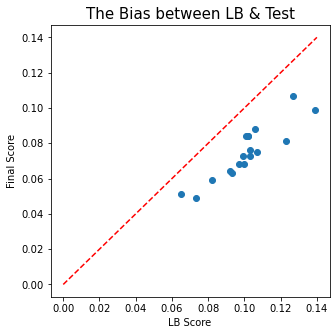

In [96]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(lb_score, fn_score)
plt.xlabel('LB Score')
plt.ylabel('Final Score')
xline = np.arange(0, 0.15, 0.01)
plt.plot(xline, xline, '--', c='r')
plt.title('The Bias between LB & Test', fontsize=15)

# EDA

In [36]:
train.head(3)

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079
2,6,0,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,...,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652,0.568848


<AxesSubplot:>

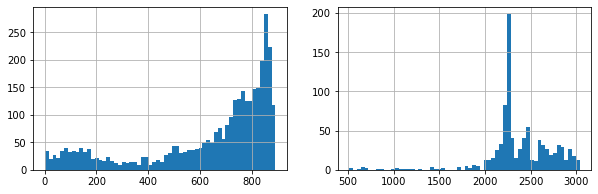

In [41]:
obs_iv = train.groupby('investment_id')['target'].count()
obs_tm = train.groupby('time_id')['target'].count()
fig = plt.figure(figsize=(10, 3))
plt.subplot(121)
obs_iv.hist(bins=60)
plt.subplot(122)
obs_tm.hist(bins=60)

Text(9.0, 0.5, 'mean target')

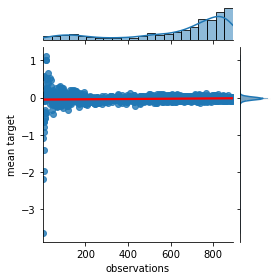

In [52]:
mean_target = train.groupby(['investment_id'])['target'].mean()
std_target = train.groupby(['investment_id'])['target'].std()
ax = sns.jointplot(x=obs_iv, y=mean_target, kind="reg", 
                   height=4, joint_kws={'line_kws':{'color':'red'}})
ax.ax_joint.set_xlabel('observations')
ax.ax_joint.set_ylabel('mean target')

Text(9.0, 0.5, 'std target')

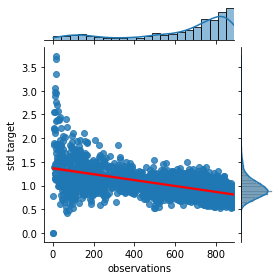

In [54]:
ax = sns.jointplot(x=obs_iv, y=std_target, kind="reg", 
                   height=4, joint_kws={'line_kws':{'color':'red'}})
ax.ax_joint.set_xlabel('observations')
ax.ax_joint.set_ylabel('std target')

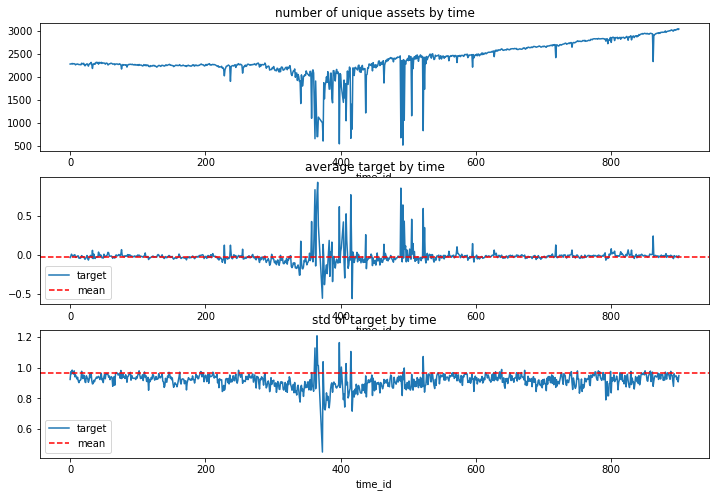

In [63]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1,)
(train.groupby('time_id')['investment_id'].nunique()).plot()
plt.title("number of unique assets by time")

plt.subplot(3, 1, 2)
train.groupby('time_id')['target'].mean().plot()
plt.title("average target by time")
plt.axhline(y=mean_target.mean(), color='r', linestyle='--', label="mean")
plt.legend(loc='lower left')

plt.subplot(3, 1, 3)
train.groupby('time_id')['target'].std().plot()
plt.title("std of target by time")
plt.axhline(y=std_target.mean(), color='r', linestyle='--', label="mean")
plt.legend(loc='lower left')

plt.show()